In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
ash_excitation = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity


#Hamiltonian 
symbols = ["H","H","H","H"]
#symbols = ["Li", "H"]
r_bohr = 5.0*1.8897259886  #5.0 Angstrom in Bohr 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
#coordinates = np.array([[0.0,0.0, 0*r_bohr], [0.0, 0.0, 1*r_bohr]])
# Calculation of the Hamiltonian
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")


electrons = 4
orbitals = 8
# Calculation of the excitation operators
singles, doubles = qml.qchem.excitations(electrons, orbitals,fermionic=False)
print('Singles are',singles)
print('Doubles are',doubles)
hf_state = qchem.hf_state(electrons, qubits)
print(f"Total number of excitations = {len(singles) + len(doubles)}")

#Calculation of HF state
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)  #HF state : [1,1,1,1,0,0,0,0] - [alpha, beta, alpha, beta, alpha, beta, alpha, beta]
    qml.BasisState(hf_state, wires=range(qubits))

    return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
print('HF state is', circuit(hf_state, electrons, qubits, H))

print('The original hamiltonian is', H)
#Putting all the functions here
#1.1091571486954503

Singles are [[0, 4], [0, 6], [1, 5], [1, 7], [2, 4], [2, 6], [3, 5], [3, 7]]
Doubles are [[0, 1, 4, 5], [0, 1, 4, 7], [0, 1, 5, 6], [0, 1, 6, 7], [0, 2, 4, 6], [0, 3, 4, 5], [0, 3, 4, 7], [0, 3, 5, 6], [0, 3, 6, 7], [1, 2, 4, 5], [1, 2, 4, 7], [1, 2, 5, 6], [1, 2, 6, 7], [1, 3, 5, 7], [2, 3, 4, 5], [2, 3, 4, 7], [2, 3, 5, 6], [2, 3, 6, 7]]
Total number of excitations = 26
Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.2160238591303294
The original hamiltonian is -1.1091571486954512 * I(0) + 0.04196325905665847 * Z(0) + 6.339400653599487e-05 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 6.339400653599487e-05 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.04183466728352239 * Z(2) + 0.015433496464844994 * (Z(0) @ Z(2)) + 6.344558587337117e-05 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 6.344558587337117e-05 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.004378038402109314 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.004378038402109314 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.04170505593332237 *

In [2]:
# Commutator calculation for HF state
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev,diff_method='backprop')
def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
    qml.BasisState(k, wires=range(qubits))
    res = qml.commutator(H, w)   #Calculating the commutator
    #res = (qml.prod(H, w)) - (qml.prod(w, H))
    return qml.expval(res)

# Commutator calculation for other states except HF state
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev,diff_method='backprop')
def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
    qml.StatePrep(k, wires=range(qubits))
    res = qml.commutator(H, w) #Calculating the commutator
    return qml.expval(res)

# Energy calculation 
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev, diff_method='backprop')
def ash(params, ash_excitation, hf_state, qubits, H):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
    for i, excitation in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            #qml.DoubleExcitation(params[i], wires = ash_excitation[i])  #Applying the double excitation and their parameters
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
        elif len(ash_excitation[i]) == 2:
            print('Single Exc going in is', ash_excitation[i])
            #qml.SingleExcitation(params[i], wires = ash_excitation[i]) #Applying the single excitation and their parameters
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.expval(H)  #Calculating the expectation value of the Hamiltonian

# Calculation of New state, same as the above function but with the state return

dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev, diff_method='backprop')
def new_state(hf_state, ash_excitation, fparams, params):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
    for i, excitations in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            print('Exc. dealing right now is', ash_excitation[i])
            print('The params that are going in', params[i])
            #qml.DoubleExcitation(params[i], wires = ash_excitation[i])
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])

        elif len(ash_excitation[i]) == 2:
            print('Single Exc. dealing right now is', ash_excitation[i])
            print('Single exc params that are going in', params[i])
            #qml.SingleExcitation(params[i], wires = ash_excitation[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

            

    return qml.state()

In [3]:

electrons = 4
orbitals = 8
singles, doubles = qml.qchem.excitations(electrons, orbitals, fermionic=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.5)  #Optimizer

print('The Hamiltonian is ', H)
adit = 6
fparams = []
excitations= []
operator_pool = (singles) + (doubles)  #Operator pool - Singles and Doubles
states = [hf_state]


for j in range(adit):
    print('The adapt iteration now is', j)  #Adapt iteration
    max_value = float('-inf')
    max_operator = None
    # Start with the most recent state (last state in the list)
    k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state

    for i in operator_pool:
        print('The current excitation operator is', i)   #Current excitation operator - fermionic one
        w = qml.fermi.jordan_wigner(i)  #JW transformation
        if np.array_equal(k, hf_state): # If the current state is the HF state
            print('Print, if this is activated - HF state')
            current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
        else:
            current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
        print(f'The expectation value of {i} is', current_value)

        if current_value > max_value:
            max_value = current_value
            max_operator = i

    print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

    # Convert operator to excitations and append to ash_excitation
    indices_str = re.findall(r'\d+', str(max_operator))
    excitations = [int(index) for index in indices_str]
    print('Highest gradient excitation is', excitations)
    ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
    print('The current status of ash_excitation is', ash_excitation)
    print('Moving towards parameters')
    params = np.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
    print('The length of parameters is', len(params))
    
    # Cost function definition
    cost_fn = qml.QNode(ash, dev, interface="autograd", diff_method="backprop") #Cost function definition, gradient calculated automatically and method is backprop
    print('Going to do energy calculation')
    for n in range(150):
        print(f'Each step, the iteration is {n} and the parameter is {params}')
        params, energy = optimizer.step_and_cost(cost_fn, params, ash_excitation=ash_excitation, hf_state=hf_state, qubits=qubits, H=H)
        if n % 5 == 0:
            print(f"step = {n}, E = {energy:.8f} Ha")
    fparams.append(params)
    print('Updated params are', params)
    print('Updated excitation are', ash_excitation)
    
    # New state generation - With the updated parameters
    ostate = new_state(hf_state, ash_excitation, fparams, params)
    print(qml.draw(new_state, level="device", max_length=100)(hf_state,ash_excitation,fparams,params))
    print('The updated state is', ostate)
    # Append the new state to the states list
    states.append(ostate)  


The Hamiltonian is  -1.1091571486954512 * I(0) + 0.04196325905665847 * Z(0) + 6.339400653599487e-05 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 6.339400653599487e-05 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.04183466728352239 * Z(2) + 0.015433496464844994 * (Z(0) @ Z(2)) + 6.344558587337117e-05 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 6.344558587337117e-05 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.004378038402109314 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.004378038402109314 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.04170505593332237 * Z(4) + 0.019843364998430146 * (Z(0) @ Z(4)) + 0.04157626163217837 * Z(6) + 0.02211221195617395 * (Z(0) @ Z(6)) + 0.04196325905665847 * Z(1) + 0.06277200433841454 * (Z(0) @ Z(1)) + 0.0025025640481208308 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + 0.0025025640481208308 * (X(0) @ Z(2) @ Z(3) @ X(4)) + 0.047312950419598196 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.047312950419598196 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.047312950419598196 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.0

/Users/cwq/CodingwithQiskit/miniconda3/envs/cwq/lib/python3.12/site-packages/autoray/autoray.py:1127: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


The expectation value of a⁺(0) a(4) is 1.5771389111457826e-05
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 1.5771389111475173e-05
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.5613738331782256e-05
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(3) a(5) is 0.0
The current excitation operator is a⁺(3) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(3) a(7) is 1.561373

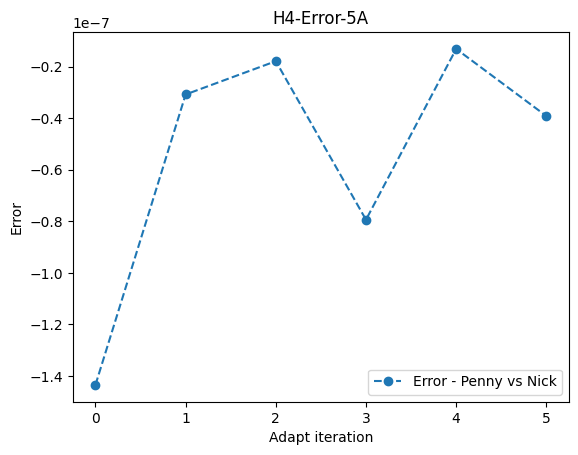

In [16]:
energy = np.array([-1.36287095, -1.53547476, -1.74957695, -1.85541375, -1.85543569,-1.8554608149793432 ])
Nick = np.array([-1.362870806544,-1.535474729162, -1.749576932070,-1.855413670588,   -1.855435676822,  -1.855460775780])
a_it = (0,1,2,3,4,5)
error = energy - Nick
import matplotlib.pyplot as plt
plt.plot(a_it, error, '--o', label = "Error - Penny vs Nick")
plt.legend()
plt.xlabel('Adapt iteration')
plt.ylabel('Error')
plt.title('H4-Error-5A')
plt.savefig("H4_5A", format= 'png', dpi = 300)
plt.show()


## Implementing scipy Minimize

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
ash_excitation = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity


#Hamiltonian 
symbols = ["H","H","H","H"]
#symbols = ["Li", "H"]
r_bohr = 3.0*1.8897259886  #5.0 Angstrom in Bohr 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
#coordinates = np.array([[0.0,0.0, 0*r_bohr], [0.0, 0.0, 1*r_bohr]])
# Calculation of the Hamiltonian
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")


electrons = 4
orbitals = 8
# Calculation of the excitation operators
singles, doubles = qml.qchem.excitations(electrons, orbitals,fermionic=False)
print('Singles are',singles)
print('Doubles are',doubles)
hf_state = qchem.hf_state(electrons, qubits)
print(f"Total number of excitations = {len(singles) + len(doubles)}")

#Calculation of HF state
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)  #HF state : [1,1,1,1,0,0,0,0] - [alpha, beta, alpha, beta, alpha, beta, alpha, beta]
    qml.BasisState(hf_state, wires=range(qubits))

    return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
print('HF state is', circuit(hf_state, electrons, qubits, H))

print('The original hamiltonian is', H)
#Putting all the functions here
#1.1091571486954503

Singles are [[0, 4], [0, 6], [1, 5], [1, 7], [2, 4], [2, 6], [3, 5], [3, 7]]
Doubles are [[0, 1, 4, 5], [0, 1, 4, 7], [0, 1, 5, 6], [0, 1, 6, 7], [0, 2, 4, 6], [0, 3, 4, 5], [0, 3, 4, 7], [0, 3, 5, 6], [0, 3, 6, 7], [1, 2, 4, 5], [1, 2, 4, 7], [1, 2, 5, 6], [1, 2, 6, 7], [1, 3, 5, 7], [2, 3, 4, 5], [2, 3, 4, 7], [2, 3, 5, 6], [2, 3, 6, 7]]
Total number of excitations = 26
Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.3325688880668933
The original hamiltonian is -1.1078408262252628 * I(0) + 0.050636412339766776 * Z(0) + 0.002022957331012548 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.002022957331012548 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.044988947930998405 * Z(2) + 0.02579174220118252 * (Z(0) @ Z(2)) + 0.0021181739685790994 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.0021181739685790994 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.006238714611182994 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.006238714611182994 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.0384102027433042 * Z

In [3]:
from scipy.optimize import minimize



dev = qml.device('default.qubit', wires=12)
#ash_excitation = [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [2, 6]]
#ash_excitation =[[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [0, 4]]
#ash_excitation = [[2, 3, 10, 11], [2, 3, 4, 11], [2, 3, 5, 10], [2, 3, 4, 5], [2, 4], [3,11]]

ash_excitation = [[2, 3, 6, 7], [0, 3, 5, 6], [0, 1, 4, 5], [1, 2, 4, 7], [0, 4], [3, 7], [2, 6], [2, 3, 6, 7], [1, 5], [0, 1, 4, 5]]


@qml.qnode(dev)
def circuit(ash_excitation, hf_state, params, H):
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]
    for i, excitation in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            #qml.DoubleExcitation(params[i], wires = ash_excitation[i])
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
        elif len(ash_excitation[i]) == 2:
            #print('Single Exc going in is', ash_excitation[i])
            #qml.SingleExcitation(params[i], wires = ash_excitation[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
    return qml.expval(H)

#def grad_callback(params, jac):
    # Calculate the norm of the gradient (jac)
#    grad_norm = np.linalg.norm(jac)
#    print(f"Current gradient norm: {grad_norm}")

def cost(params):
    energy = circuit(ash_excitation, hf_state, params, H)
    return energy

def callback(params):
    print(f"Current parameters: {params}")
    print(f"Current cost: {cost(params)}\n")

params = np.array([0.99, 0.012, 0.05, 0.5,0.5, 0.99, 0.012, 0.05, 0.5,0.5], requires_grad=True)

#print(minimize(cost, params, method='BFGS'))

result = minimize(cost, params, method='BFGS', callback=callback)

print("Final parameters:", result.x)
print("Final cost:", result.fun)

#(2,10) - 7.796455906926855

Current parameters: [ 0.53041496 -0.06200312 -0.5151322   0.50836283  0.64620736  1.57834918
 -0.3916925  -0.21446812  0.19530687 -0.02871622]
Current cost: -1.4227943153833535

Current parameters: [ 0.22697095 -0.15370251 -0.90290662  0.43109196  0.78571432  1.99384866
 -0.70867962 -0.41204359 -0.09488058 -0.41730382]
Current cost: -1.5323680214574427

Current parameters: [ 0.16093169 -0.24626944 -0.91110888  0.27122598  0.81669926  2.05267383
 -0.82760117 -0.45870223 -0.24547842 -0.51489846]
Current cost: -1.5933171113917959

Current parameters: [ 0.07493889 -0.40239237 -0.81186305 -0.03938537  0.86019188  2.03175508
 -0.99387964 -0.49463667 -0.48487416 -0.61940035]
Current cost: -1.7002807945282676

Current parameters: [-0.10732238 -0.6614952  -0.4806723  -0.65847171  0.96541425  1.80204411
 -1.26388228 -0.47814822 -0.91898091 -0.7407423 ]
Current cost: -1.804541633135367

Current parameters: [-0.14252708 -0.59914411 -0.44785718 -0.60486284  0.98297342  1.70857418
 -1.19761312 -0.40

In [17]:
## 3A 
s = []

print(s)
#params.extend(result.x.eval())
#params.extend(result.x.numpy().tolist())
#params.extend(result.x.detach().numpy().tolist())
params = result.x
print(params)


[]
[-0.84320229 -1.36721676 -1.04888561 -1.22835262  1.7133739   1.71170841
 -1.42974409  0.08012622 -1.42806703  0.0781386 ]


## Jax interface - Optax

In [ ]:
import jax
from jax import numpy as jnp
import pennylane as qml
import optax
import jax.numpy as jnp
from pennylane import qchem
from pennylane import numpy as np

jax.config.update("jax_enable_x64", True)


X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity

symbols = ["H","H","H","H"]
r_bohr = 5.0*1.8897259886
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method = "pyscf")

print('The original hamiltonian is', H)
electrons = 4
orbitals = 8
qubits = 8
singles, doubles = qml.qchem.excitations(electrons, orbitals,fermionic=True)
print('Singles are',singles)
print('Doubles are',doubles)
hf_state = qchem.hf_state(electrons, qubits)
print(f"Total number of excitations = {len(singles) + len(doubles)}")



dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)
    qml.BasisState(hf_state, wires=range(qubits))
    #[qml.PauliX(i) for i in jnp.nonzero(hf_state)[0]] #HF state

    return qml.expval(H)
print('HF state is', circuit(hf_state, electrons, qubits, H))

#dev = qml.device("default.qubit", wires=qubits)

#@jax.jit
#@qml.qnode(dev, interface="jax")
#def circuit(param):
#    qml.RX(param, wires=0)
##    qml.CNOT(wires=[0, 1])
#    return qml.expval(H)

#ash_excitation = [[2,6],[1, 2, 4, 7],[0,1,4,5],[0, 3, 5, 6],[2, 3, 6, 7]]
#ash_excitation =  [[3, 7], [0, 4], [1, 2, 4, 7], [0, 1, 4, 5], [0, 3, 5, 6], [2, 3, 6, 7]]
ash_excitation =  [[2,3,6,7], [0,3,5,6], [0,1,4,5], [1,2,4,7], [2,6]]

optimizer = optax.adam(learning_rate=0.1)
#optimizer = optax.lbfgs()
params = jnp.zeros(len(ash_excitation), dtype=jnp.float32)
opt_state = optimizer.init(params)
print('The parameters that are going in ', len(params))

dev = qml.device("default.qubit", wires=qubits)

# QNode to evaluate energy
@qml.qnode(dev)
#@jax.jit
@qml.qnode(dev, interface="jax")
def circuit(params, ash_excitation, hf_state, qubits, H):
    qml.BasisState(hf_state, wires=range(qubits))
    for i, excitations in enumerate(ash_excitation):
        if len(excitations) == 4:
            #Exchanged the order of wires 1 and wires 2
            #qml.FermionicDoubleExcitation(weight = params[i], wires2=excitations[2:][::-1], wires1=excitations[:2][::-1])
            qml.FermionicDoubleExcitation(weight = params[i], wires1=excitations[2:][::-1], wires2=excitations[:2][::-1])
        else:
            #print(f'Single excitations coming in is {excitations} and parameters are {params[i]}')
            qml.FermionicSingleExcitation(weight= params[i], wires = excitations)
    return qml.expval(H)

def cost_fn(params, ash_excitation, hf_state, qubits, H):
    # Compute the energy
    energy = circuit(params, ash_excitation, hf_state, qubits, H)
    return energy

def minimize_function(params):
    energy= cost_fn(params, ash_excitation, hf_state, qubits, H)
    return energy

gradient_tolerance = 1e-8 
gradient_max_threshold = 1e-8
for i in range(250):
    #cost, grad_circuit = jax.value_and_grad(circuit)(params)
    cost, grad_circuit = jax.value_and_grad(minimize_function)(params)
        # Compute the norm of the gradient
    grad_norm = jnp.linalg.norm(grad_circuit)
    grad_max = jnp.max(jnp.abs(grad_circuit))


    # Print the current gradient norm (optional for debugging)
    print(f"Step {i}, cost: {cost}, grad_norm: {grad_norm}, grad_max: {grad_max}")

    # Check if the gradient norm is below the tolerance
    if grad_norm < gradient_tolerance:
        print(f"Convergence achieved at step {i}. Gradient norm {grad_norm} is below tolerance.")
        break
    if grad_max < gradient_max_threshold:
        print(f"Convergence achieved at step {i}. Maximum gradient {grad_max} is below the threshold.")
        break 
    updates, opt_state = optimizer.update(grad_circuit, opt_state)
    params = optax.apply_updates(params, updates)
    #print(f"step {i}, cost {cost}")
print('Final energy is', cost)